# Increasing Efficiency of Heart Disease Diagnoses Using Two Binary Classification Models


## Preliminary Scripts

In [15]:
# install statements
!pip install gosdt
!pip install -U scikit-learn

# useful import statements
import io
import math
import numpy as np
import pandas as pd

# sklearn imports
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn import linear_model
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# plotting imports
import seaborn as sns 
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats

# mathematical helper imports
from scipy.optimize import approx_fprime
from numpy.linalg import norm

# other imports
import warnings
import pickle
import os

Requirement already up-to-date: scikit-learn in c:\users\hkhadri\anaconda3\envs\learn-env\lib\site-packages (1.2.1)


In [16]:
# file upload
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

## Helper Functions

#### Scoring Models Based on f1, AUC, Accuracy, and Sparsity

In [17]:
# @FUNCTION: Helper to Score Model;
# [args: model, model_type, X, Y, scores]
def modelScoring(model, X, Y, scores):
    # initialize return array

    # generate model predictions on test folds
    preds = model.predict(X)

    # calculate performance metrics
    f1Score = metrics.f1_score(Y, preds)
    aucScore = metrics.roc_auc_score(Y, model.predict_proba(X)[:,1])
    accScore = metrics.accuracy_score(Y, preds)
    sparScore = 0

   
    coefs = model.feature_importances_
    sparScore = 1.0 - (np.count_nonzero(coefs) / 13)
    
    # append data to scores arrays
    for key,val in scores.items():
        if key == 'accuracy': val.append(accScore)
        elif key == 'auc': val.append(aucScore)
        elif key == 'f1': val.append(f1Score)
        elif key == 'sparsity': val.append(sparScore)

#### Performing K-Fold Cross Validation on a Model with Data

In [18]:
# @FUNCTION: K-Fold CV; 
# [args: model, data, labels, k (num folds), type (regr, gbc, rfc, svm)]
def kfold(model, data, labels, k):
    
    # Create the KFold object
    kf = KFold(n_splits=k)

    # Create a list to store the performance of the model on each fold
    scores = {'accuracy': [], 'auc': [], 'f1': [], 'sparsity': []}
    performance = {'accuracy': 0, 'auc': 0, 'f1': 0, 'sparsity': 0}

    # Iterate over the splits
    for train_index, test_index in kf.split(data):
        # get training and test data
        trainfoldX, testfoldX = data[train_index], data[test_index]
        trainfoldY, testfoldY = labels[train_index], labels[test_index]

        # train model
        model.fit(trainfoldX, trainfoldY)

        # compute scores for this training fold
        modelScoring(model, testfoldX, testfoldY, scores)

    # add average values to performance
    performance['accuracy'] = sum(scores['accuracy']) / len(scores['accuracy'])
    performance['auc'] = sum(scores['auc']) / len(scores['auc'])
    performance['f1'] = sum(scores['f1']) / len(scores['f1'])
    performance['sparsity'] = sum(scores['sparsity']) / len(scores['sparsity'])

    # Return the average performances, metrics of the model
    return scores, performance

# Data processing

I used the raw source of the dataset, which is linked on University of Cleveland’s ML data source website


In [19]:
# load csv file into pandas dataframe
data = pd.read_csv("raw_heart_data.txt", sep='\s+', header = None) 


In [20]:
# add columns to dataset
classes = ['Age', 'Sex', 'CP', 'RestingBP', 'Chol', 
                'FBS', 'RestingECG', 'MaxHR', 'ExAngina', 
                'OldPeak', 'Slope', 'NumVessels', 'Thal', 
                'Label', 'LabelDesc']
data.columns = classes

In [21]:
# dropping label_desc, unnecessary for binary classification task
data = data.drop('LabelDesc', axis=1)


# drop any incomplete feature vectors (containing ?)
data = data.replace({'?': np.nan}).dropna()
data = data.reset_index(drop=True)


In [22]:
# replace categorical data with symbolic numerical data
data.loc[data['Sex'] == 'male', 'Sex'] = 0; data.loc[data['Sex'] == 'fem', 'Sex'] = 1

data.loc[data['CP'] == 'angina', 'CP'] = 0; data.loc[data['CP'] == 'abnang', 'CP'] = 1
data.loc[data['CP'] == 'notang', 'CP'] = 2; data.loc[data['CP'] == 'asympt', 'CP'] = 3

data.loc[data['FBS'] == 'fal', 'FBS'] = 0; data.loc[data['FBS'] == 'true', 'FBS'] = 1

data.loc[data['RestingECG'] == 'norm', 'RestingECG'] = 0
data.loc[data['RestingECG'] == 'abn', 'RestingECG'] = 1
data.loc[data['RestingECG'] == 'hyp', 'RestingECG'] = 2

data.loc[data['ExAngina'] == 'fal', 'ExAngina'] = 0; data.loc[data['ExAngina'] == 'true', 'ExAngina'] = 1 

data.loc[data['Slope'] == 'up', 'Slope'] = 0
data.loc[data['Slope'] == 'flat', 'Slope'] = 1
data.loc[data['Slope'] == 'down', 'Slope'] = 2 

data.loc[data['Thal'] == 'norm', 'Thal'] = 0
data.loc[data['Thal'] == 'fix', 'Thal'] = 1
data.loc[data['Thal'] == 'rev', 'Thal'] = 2 

data.loc[data['Label'] == 'buff', 'Label'] = 0; data.loc[data['Label'] == 'sick', 'Label'] = 1

# ensure that all categorical values have been assigned numerically
print(f"All Assigned? {data.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all()).all() == True}\n")

# show data
data

All Assigned? True



,Age,Sex,CP,RestingBP,Chol,FBS,RestingECG,MaxHR,ExAngina,OldPeak,Slope,NumVessels,Thal,Label
0,63.0,0,0,145.0,233.0,1,2,150.0,0,2.3,2,0.0,1,0
1,67.0,0,3,160.0,286.0,0,2,108.0,1,1.5,1,3.0,0,1
2,67.0,0,3,120.0,229.0,0,2,129.0,1,2.6,1,2.0,2,1
3,37.0,0,2,130.0,250.0,0,0,187.0,0,3.5,2,0.0,0,0
4,41.0,1,1,130.0,204.0,0,2,172.0,0,1.4,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,48.0,0,2,124.0,255.0,1,0,175.0,0,0.0,0,2.0,0,0
292,57.0,0,3,132.0,207.0,0,0,168.0,1,0.0,0,0.0,2,0
293,49.0,0,2,118.0,149.0,0,2,126.0,0,0.8,0,3.0,0,1
294,74.0,1,1,120.0,269.0,0,2,121.0,1,0.2,0,1.0,0,0


## Exploratory Data Analysis



### Splitting Dataset into Train and Test
We perform EDA on only the training subset to avoid overfitting and feature selection bias.

In [23]:
# split data into training and testing
train, test = train_test_split(data, test_size = 0.2, random_state = 0)


#### Computing Relevant Statistical Information for Each Feature

In [24]:
numData = train.select_dtypes(exclude='object')

stats = numData.describe().T
stats['skew'] = numData.skew()
stats['kurtosis'] = numData.kurtosis()

display(stats)


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Age,236.0,54.525424,9.150479,34.0,47.00,56.0,61.0,77.0,-0.191110,-0.684541
RestingBP,236.0,132.165254,18.196861,94.0,120.00,130.0,140.0,200.0,0.691000,0.887535
Chol,236.0,249.135593,52.932541,141.0,213.00,243.0,282.0,564.0,1.294488,5.084472
MaxHR,236.0,150.228814,23.008199,71.0,132.75,154.0,169.0,195.0,-0.523446,-0.129002
OldPeak,236.0,1.113983,1.218621,0.0,0.00,0.8,1.8,6.2,1.193361,1.291993


# Data Visualization
#### Using Histograms to Visualize Frequency/Distributon of Features


<ipython-input-25-eef4ab84f04b>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


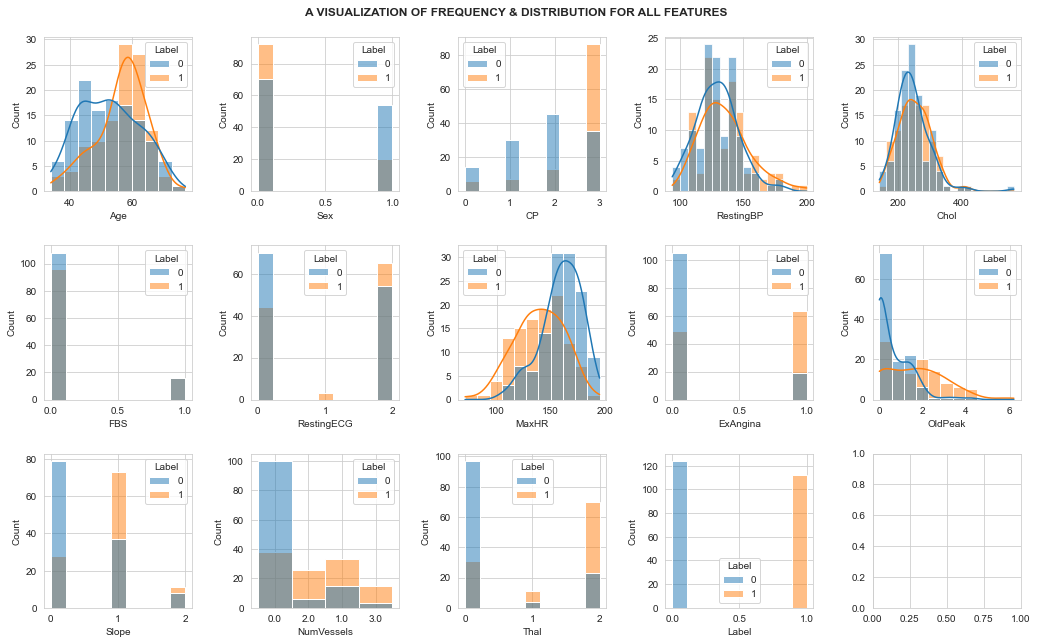

In [25]:
sns.set_style('whitegrid')

# create subplot grid and edit some plot characteristics
fig, ax = plt.subplots(3, 5)
fig.suptitle("A VISUALIZATION OF FREQUENCY & DISTRIBUTION FOR ALL FEATURES", y = 0.92, weight='bold')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.35)
fig.set_size_inches(17.5, 10.5, forward=True)

# loop through subplots and add seaborn plots for each feature
count = 0
for i in range(3):
    for j in range(5):
        if count < 14:
            if train[train.columns[count]].dtypes == float:
                sns.histplot(ax=ax[i,j], x=train[train.columns[count]], hue='Label', data=train, kde=True)
            else: 
                sns.histplot(ax=ax[i,j], x=train[train.columns[count]], hue='Label', data=train)
        count += 1

# display the figure
fig.show()

#### Using Boxplots to Understand Data Outliers

<ipython-input-27-8b0042df5aa4>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


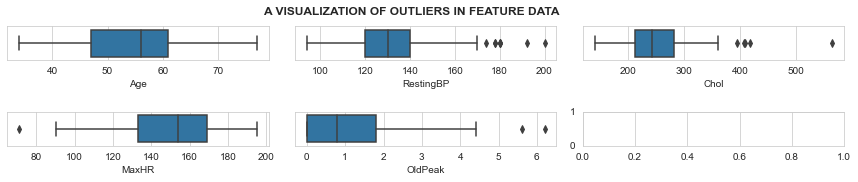

In [27]:
sns.set_style('whitegrid')

# create subplot grid and edit some plot characteristics
fig, ax = plt.subplots(2, 3)
fig.suptitle("A VISUALIZATION OF OUTLIERS IN FEATURE DATA", y = 1, weight='bold')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=1.5)
fig.set_size_inches(15, 2.2, forward=True)

# loop through subplots and add seaborn plots for each feature
count = 0
for i in range(2):
    for j in range(3):
        if count < 5:
            sns.boxplot(ax=ax[i,j], data=numData, 
                        x=numData[numData.columns[count]], dodge=True)
        count += 1

fig.show()

#### Using Boxplots to Visualize Feature Classification

<ipython-input-28-04a18aa8ca14>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


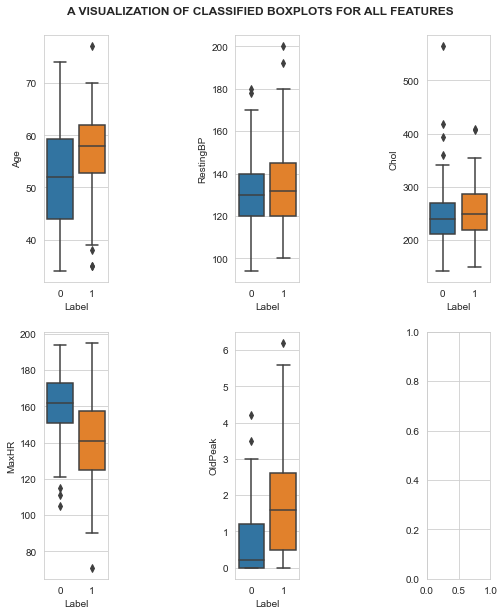

In [28]:
sns.set_style('whitegrid')

# create subplot grid and edit some plot characteristics
fig, ax = plt.subplots(2, 3)
fig.suptitle("A VISUALIZATION OF CLASSIFIED BOXPLOTS FOR ALL FEATURES", y = 0.92, weight='bold')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2, hspace=0.2)
fig.set_size_inches(8, 10, forward=True)

# loop through subplots and add seaborn plots for each feature
count = 0
numDataLabeled = numData.copy()
numDataLabeled['Label'] = train['Label']

for i in range(2):
    for j in range(3):
        if count < 5:
            sns.boxplot(ax=ax[i,j], data=numDataLabeled, 
                        y=numData[numDataLabeled.columns[count]], x="Label", dodge=True)
        count += 1

fig.show()


#### Using a Heatmap to Visualize Correlation Between Features

In [29]:
df_heatmap = train.copy()
for col in data.columns:
    df_heatmap[col] = df_heatmap[col].astype('float')


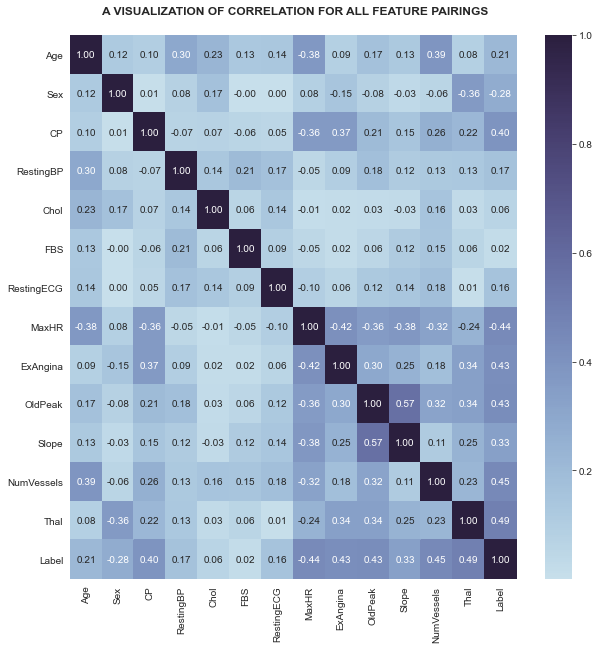

In [28]:
# create figure and edit title/colors
plt.figure(figsize=(10,10))
plt.suptitle("A VISUALIZATION OF CORRELATION FOR ALL FEATURE PAIRINGS", x=0.4375, y = 0.92, weight='bold')
colors = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

# coloring gradient for strength of correlation, use abs_val of data.corr()
absCorr = pd.DataFrame([abs(x) for x in df_heatmap.corr().to_numpy()])
absCorr.columns = df_heatmap.columns; absCorr.index = df_heatmap.columns

# plot the heatmap using seaborn, annotated with original values
sns.heatmap(absCorr, cmap=colors, annot=df_heatmap.corr(), fmt=".2f")

# display the plot
plt.show()


## Feature Engineering Algorithms

In [30]:
# @FUNCTION: handles outliers from df (dataframe) in place
# [args: df (DataFrame object), method ('rm'-remove, 'mean'-replace with avg, 'med'-replace with median)]
def handleOutlier(df, method='rm'):
    for col in df.columns:
        if df.dtypes[col] != 'object':
            outliers = [y for stat in boxplot_stats(df[col]) for y in stat['fliers']]    
            for out in outliers:
                if method == 'rm':
                    df.drop(df[df[col] == out].index, inplace = True)
                elif method == 'mean':
                    df[col].replace(out,np.mean(df[col]), inplace=True)
                elif method == 'med':
                    df[col].replace(out,np.median(df[col]), inplace=True)
    return df

In [31]:
# @FUNCTION: handles low/moderate/high skew from df in place
# [args: df (DataFrame object), tol (numerical skew tolerance, default 1)]
def handleSkew(df, df2, tol=1, method='log'):
    for col in df.columns:
        if df.dtypes[col] != 'object':
            if abs(df[col].skew()) >= tol:
                if method == 'log': 
                    df[col] = np.log(df[col], where=(df[col]!=0))
                    df2[col] = np.log(df2[col], where=(df2[col]!=0))
                elif method == 'sqrt':
                    df[[col]] = StandardScaler().fit_transform(df[[col]]) 
                    df[col] = np.sqrt(np.absolute(df[col]))
                    df2[[col]] = StandardScaler().fit_transform(df2[[col]]) 
                    df2[col] = np.sqrt(np.absolute(df2[col]))
    return df, df2

## Training Algorithm - Gradient Boosting Classifier

#### Baseline GBC

In [32]:
# remove outliers
trainGBC = handleOutlier(train.copy())

# split training and testing data further into features + labels
trainX = trainGBC.drop('Label', axis=1).to_numpy()
trainY = trainGBC.iloc[:,-1].astype('int').to_numpy()

testX = test.drop('Label', axis=1).to_numpy()
testY = test.iloc[:,-1].astype('int').to_numpy()

modelGBC = GradientBoostingClassifier(random_state=0)
modelGBC.fit(trainX, trainY)
GBCScores = {'accuracy': [], 'auc': [], 'f1': [], 'sparsity': []}
modelScoring(modelGBC, testX, testY, GBCScores)

GBCScores = pd.DataFrame(GBCScores)
display(GBCScores)

,accuracy,auc,f1,sparsity
0,0.8,0.913194,0.76,0.0


#### Hyperparameter Tuning and Optimized Model

In [33]:
# initialize hyperparameter arrays
nEstimatorRange = [10, 100, 200, 300, 400]; maxDepthRange = [3,5,10,15,20]
minSamplesSplitRange = [2, 4, 6, 8, 10]

modelGBC = GradientBoostingClassifier(random_state=0)
param_gridGBC = {'n_estimators': nEstimatorRange, 'max_depth': maxDepthRange, 'min_samples_split': minSamplesSplitRange}

paramGBC = GridSearchCV(modelGBC, param_gridGBC, scoring='roc_auc', return_train_score=True)
paramGBC.fit(trainX, trainY)

gridGBCScores = {'accuracy': [], 'auc': [], 'f1': [], 'sparsity': []}
modelScoring(paramGBC.best_estimator_, testX, testY, gridGBCScores)

gridGBCScores = pd.DataFrame(gridGBCScores)
display(gridGBCScores)

,accuracy,auc,f1,sparsity
0,0.866667,0.930556,0.818182,0.230769


In [34]:
# compile feature importances into dataframe and display
ftiGBC = pd.DataFrame(columns = classes[0:13])
ftiGBC.loc['weights'] = paramGBC.best_estimator_.feature_importances_
display(ftiGBC)


,Age,Sex,CP,RestingBP,Chol,FBS,RestingECG,MaxHR,ExAngina,OldPeak,Slope,NumVessels,Thal
weights,0.036761,0.037192,0.173948,0.0,0.011573,0.0,0.0,0.031619,0.007639,0.10724,0.055215,0.208636,0.330177


##### II. Extracting Feature Importance

<AxesSubplot:title={'center':'FEATURE IMPORTANCE BASED ON HYPERPARAMETER-TUNED GBC MODEL'}, ylabel='weights'>

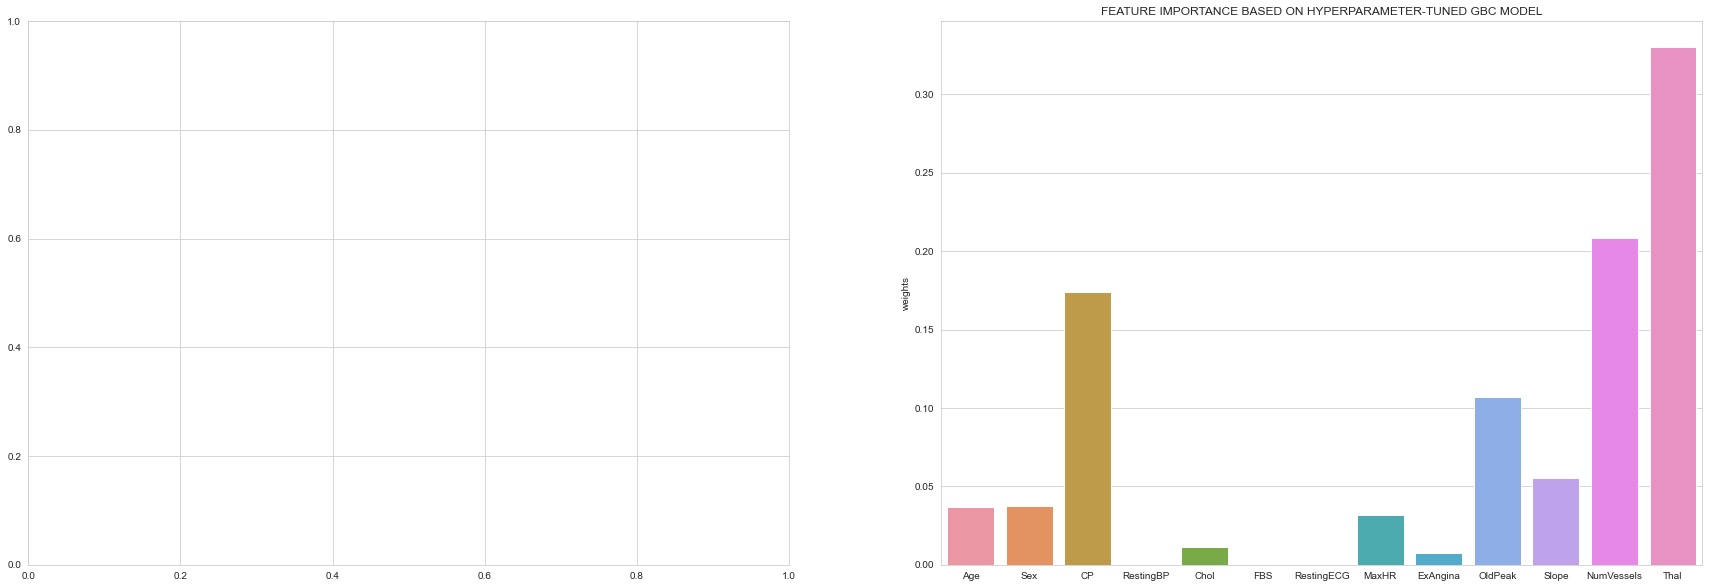

In [35]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(30, 10, forward=True)
plt.title('FEATURE IMPORTANCE BASED ON HYPERPARAMETER-TUNED GBC MODEL')
sns.barplot(ax = ax[1], x=ftiGBC.columns,y=ftiGBC.loc['weights'])